<a href="https://colab.research.google.com/github/Kagiany/2025/blob/main/GenAI_ML_HW2_Build_a_Basic_RAG_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GenAI-ML-HW2-Build a Basic RAG System

This notebook is for **Introduction to GenAI and ML 2025 Fall** Homework 2, focusing on Retrieval Augmented Generation (RAG) implementation on Hónglóu mèng dataset. The goal is to enhance RAG system performance via different retrieval models, better preprocessing on the dataset, and prompt formatting.

- [Course Website](https://speech.ee.ntu.edu.tw/~hylee/GenAI-ML/2025-fall.php)
- [Homework Slide Link](https://docs.google.com/presentation/d/1mlr12fgyEkuliYcaFK4a52hg6OD5esHoKlty_WAGpgE/edit?usp=sharing)

## Activate GPU

To enable GPU, please follow these steps:

1. Click on "Runtime" (or "執行階段") in the header.
2. Click on "Change runtime type" (or "變更執行階段類型") in the drop menu.
3. Select "T4 GPU" and save. (You can select "A100 GPU" or "V100 GPU" if you have Colab Pro)
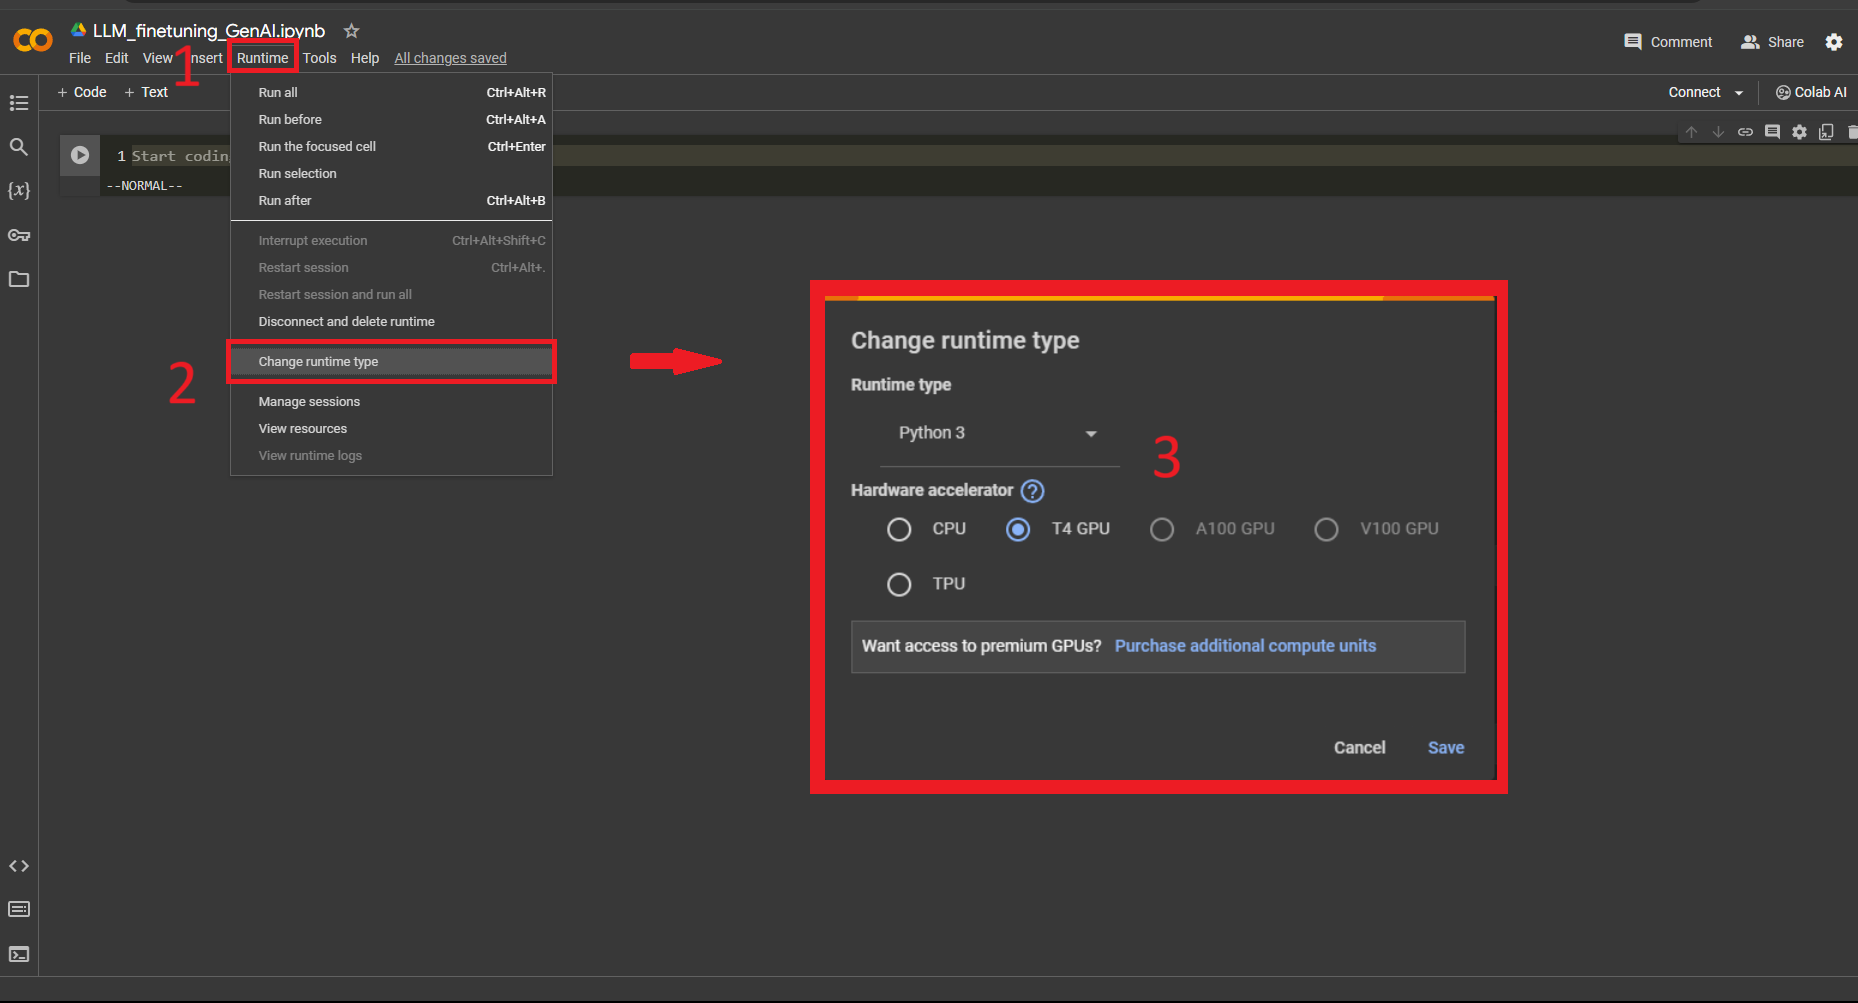

## Check GPU

In [1]:
!nvidia-smi

Sat Sep 20 11:35:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Download Dataset

In [2]:
!wget https://www.csie.ntu.edu.tw/~b10902031/test_public.jsonl # public test dataset
!wget https://www.csie.ntu.edu.tw/~b10902031/test_private.jsonl # private test dataset
!wget https://www.csie.ntu.edu.tw/~b10902031/hongloumeng_fulltext.txt # knowledge base

--2025-09-20 11:35:54--  https://www.csie.ntu.edu.tw/~b10902031/test_public.jsonl
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12795 (12K)
Saving to: ‘test_public.jsonl’

test_public.jsonl   100%[===================>]  12.50K  --.-KB/s    in 0s      

2025-09-20 11:35:54 (166 MB/s) - ‘test_public.jsonl’ saved [12795/12795]

--2025-09-20 11:35:54--  https://www.csie.ntu.edu.tw/~b10902031/test_private.jsonl
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6513 (6.4K)
Saving to: ‘test_private.jsonl’

test_private.jsonl  100%[===================>]   6.36K  --.-KB/s    in 0s      

2025-09-20 11:35:54 (269 MB/s) - ‘test_private.jsonl’ saved [6513/6513]

--2025-09-2

## Download and Import Packages

In [3]:
!pip install -U bitsandbytes rank_bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.5 MB/s eta 0:00:00


In [4]:
# 載入所需的套件（Packages）
# Import necessary libraries

import json                         # 處理 JSON 格式資料的標準套件 / Standard JSON library
import torch                        # PyTorch 是一個深度學習框架 / PyTorch deep learning framework
from typing import List             # 用來註解 List 型別 / Type annotation for list
from transformers import (          # Transformers 模型相關函式庫 / HuggingFace Transformers library
    AutoModelForCausalLM,           # 自動載入因果語言模型 / Auto loader for causal language models
    AutoTokenizer,                  # 自動載入對應的 tokenizer / Auto loader for tokenizer
    BitsAndBytesConfig,             # 用來設定量化模型的參數 / Configuration for model quantization
    pipeline                        # 提供簡單的模型推論介面 / Easy interface for model inference
)
from tqdm.autonotebook import tqdm  # 顯示進度條（適用於 Jupyter Notebook） / Progress bar in Jupyter
import jieba                        # 中文斷詞工具 / Chinese word segmentation
from rank_bm25 import BM25Okapi     # BM25 搜尋模型 / BM25 retrieval model
from sentence_transformers import SentenceTransformer  # 向量模型 / Sentence embedding model

/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
  re_skip_default = re.compile("(\r\n|\s)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")


KeyboardInterrupt: 

## Load Queries

In [ ]:
# 載入問題（queries），來自兩個 JSONL 檔案
# Load query data from two `.jsonl` files

queries = []
with open("test_public.jsonl", "r") as fp:
    lines = fp.readlines()
    for line in lines:
        query = json.loads(line)['query']  # 將 JSON 格式轉換成 Python 字典 / Parse JSON and extract "query"
        queries.append(query)
with open("test_private.jsonl", "r") as fp:
    lines = fp.readlines()
    for line in lines:
        query = json.loads(line)['query']
        queries.append(query)

## Load Knowledge Base and Process into Chunks (TODO)

In [5]:
# 載入紅樓夢全文，並分段處理（每段長度為 chunk_size）
# Load the full text of Hong Lou Meng and split it into fixed-size chunks

chunks = []                   # 存放每段文字的清單 / List to store text chunks
passage = ""                     # 存放全文的變數 / Full text content
chunk_size = 512                # 每段文字的長度上限 / Size of each chunk
stride = 512                   # 每段間的步長 / Stride between chunks
                               # TODO: For boss baseline, adjust 'chunk_size' and 'stride'
with open("hongloumeng_fulltext.txt", "r") as fp:
    passage = fp.read()         # 讀取整本書的文字內容 / Read the full book content

length = len(passage)
for i in range(0, length, stride):
    chunk = passage[i:i+chunk_size]  # 依照 chunk_size 切出文字段落 / Slice text into chunks
    chunks.append(chunk)

## Retrieval

### Load Retrieval Models

In [ ]:
# 初始化兩種檢索模型：BM25 和向量模型
# Initialize two retrieval models: BM25 and embedding-based

# 建立 BM25 模型所需的斷詞資料 / Tokenize each chunk using jieba for BM25
tokenized_chunks = [list(jieba.cut(chunk)) for chunk in chunks]
bm25 = BM25Okapi(tokenized_chunks)  # 建立 BM25 檢索模型 / Build BM25 retrieval object

# 載入語句向量模型（Embedding Model）/ Load the sentence transformer model
embedding_model = SentenceTransformer("intfloat/multilingual-e5-large")

# 對所有 chunks 計算向量 / Encode chunks into embeddings
chunks_embeddings = embedding_model.encode(chunks, show_progress_bar=True)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.139 seconds.
DEBUG:jieba:Loading model cost 1.139 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Batches:   0%|          | 0/54 [00:00<?, ?it/s]

### Retrieval Functions

In [ ]:
# 定義 BM25 檢索函式 / Define retrieval function using BM25
def bm25_retrieve(query: str, chunks: List[str], bm25: BM25Okapi) -> List[str]:
    tokenized_query = list(jieba.cut(query))  # 對查詢進行斷詞 / Tokenize the query
    scores = bm25.get_scores(tokenized_query) # 計算每段文字的分數 / Get relevance scores
    rank = sorted(zip(chunks, scores), key=lambda x: x[1], reverse=True)  # 依分數排序 / Rank by score
    return [chunk for chunk, _ in rank]   # 回傳排序後的段落 / Return ranked chunks

# 定義向量檢索函式 / Define retrieval function using embedding similarity
def embedding_retrieve(query: str, chunks: List[str], chunks_embeddings: List[str], embedding_model: SentenceTransformer) -> List[str]:
    query_embeddings = embedding_model.encode(query, prompt_name="query")  # 取得查詢的向量表示 / Encode query
    scores = list(embedding_model.similarity(query_embeddings, chunks_embeddings)[0])  # 計算相似度 / Compute similarities
    rank = sorted(zip(chunks, scores), key=lambda x: x[1], reverse=True)  # 排序 / Rank by score
    return [chunk for chunk, _ in rank]

# 定義 Reciprocal Rank Fusion 函式，融合多種排序 / Combine multiple rankings using RRF
def reciprocal_rank_fusion(*ranked_lists, k=60) -> List[str]:
    scores = {}
    for rl in ranked_lists:
        for rank, doc_id in enumerate(rl, start=1):  # rank 從 1 開始 / Rank is 1-based
            scores[doc_id] = scores.get(doc_id, 0.0) + 1.0 / (k + rank)

    fused = sorted(scores.items(), key=lambda x: (-x[1], x[0]))  # 排序並融合 / Sort fused scores
    return [d for d, _ in fused]

## Load LLM

In [ ]:
# 設定量化參數，減少記憶體使用 / Set quantization settings for smaller memory usage
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                    # 使用 4-bit 權重 / Use 4-bit weights
    bnb_4bit_use_double_quant=True,       # 啟用雙重量化 / Enable double quantization
    bnb_4bit_quant_type="nf4",            # 使用 nf4 量化類型 / Quantization type
    bnb_4bit_compute_dtype=torch.bfloat16 # 使用 bfloat16 進行計算 / Use bfloat16 for compute
)
# 載入微調好的語言模型（Gemma）/ Load pretrained LLM
llm = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path="unsloth/gemma-3-4b-it",
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
)
# 載入對應的 tokenizer / Load tokenizer for the model
tokenizer = AutoTokenizer.from_pretrained(
    "unsloth/gemma-3-4b-it",
)
# 使用 pipeline 包裝模型推論介面 / Create a pipeline for generation
llm_pipe = pipeline(
    "text-generation",           # 任務為文本生成 / Task type
    model=llm,                   # 使用的模型 / LLM
    tokenizer=tokenizer,        # tokenizer
    max_new_tokens=256,         # 回應最大長度 / Maximum new tokens
    do_sample=False,            # 不使用隨機 sampling（使用貪婪解碼）/ Greedy decoding
    temperature=None,
    top_p=None,
    top_k=None,
)

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Device set to use cuda:0


### Define Prompts

In [ ]:
# 定義提示語（prompt），用來告訴模型角色與任務
# Define system/user prompts to guide the model's behavior

SIMPLE_SYSTEM_PROMPT = """
你是一位精通中國古典文學《紅樓夢》的專家。
請根據提問，直接提供精簡並準確的解答，避免與問題無關的內容。
""".strip()

SYSTEM_PROMPT = """
你是一位精通中國古典文學《紅樓夢》的專家。
請根據**問題**，從使用者提供的**《紅樓夢》文章片段**找出與問題相關的內容，直接提供精簡並準確的解答，避免與問題無關的內容。
""".strip()

USER_PROMPT = """
### 問題
{query}
### 《紅樓夢》文章片段
{relevant_chunks}
""".strip()

## Run RAG

- One block is for one baseline
- You can only excute one block for prediction file

### Simple Baseline

In [ ]:
# 簡易 baseline：直接將 query 丟給模型回答，不使用知識庫
# Simple baseline: no retrieval, direct question answering

responses = []
for query in tqdm(queries, desc="Response Generation"):
    chats = [
        {'role': "system", 'content': SIMPLE_SYSTEM_PROMPT},
        {'role': "user", 'content': query},
    ]
    response = llm_pipe(chats)[0]['generated_text'][-1]['content'].strip()
    responses.append(response[:512])

Response Generation:   0%|          | 0/100 [00:00<?, ?it/s]

`generation_config` default values have been modified to match model-specific defaults: {'do_sample': True}. If this is not desired, please set these values explicitly.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


KeyboardInterrupt: 

### Medium Baseline

In [ ]:
# 中等 baseline：只使用 BM25 找前 10 個段落，給模型參考
# Medium baseline: use top 10 BM25 chunks for retrieval-augmented generation

responses = []
for query in tqdm(queries, desc="Response Generation"):
    relevant_chunks = "\n\n".join(bm25_retrieve(query=query, chunks=chunks, bm25=bm25)[:10])
    chats = [
        {'role': "system", 'content': SYSTEM_PROMPT},
        {'role': "user", 'content': USER_PROMPT.format(query=query, relevant_chunks=relevant_chunks)},
    ]
    response = llm_pipe(chats)[0]['generated_text'][-1]['content'].strip()
    responses.append(response[:512])

Response Generation:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Strong Baseline

In [ ]:
# 強 baseline：結合 BM25 + 向量檢索，使用 RRF 融合排序
# Strong baseline: combine BM25 and embedding-based results using RRF

responses = []
for query in tqdm(queries, desc="Response Generation"):
    relevant_chunks_bm25 = bm25_retrieve(query=query, chunks=chunks, bm25=bm25)
    relevant_chunks_embedding = embedding_retrieve(
        query=query,
        chunks=chunks,
        chunks_embeddings=chunks_embeddings,
        embedding_model=embedding_model
    )
    relevant_chunks = "\n\n".join(reciprocal_rank_fusion(relevant_chunks_bm25, relevant_chunks_embedding)[:10])

    chats = [
        {'role': "system", 'content': SYSTEM_PROMPT},
        {'role': "user", 'content': USER_PROMPT.format(query=query, relevant_chunks=relevant_chunks)},
    ]
    response = llm_pipe(chats)[0]['generated_text'][-1]['content'].strip()
    responses.append(response[:512])

Response Generation:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Boss Baseline (TODO)

In [ ]:
# Boss baseline：使用更多段落
# Boss baseline: more fused chunks

responses = []
for query in tqdm(queries, desc="Response Generation"):
    relevant_chunks_bm25 = bm25_retrieve(query=query, chunks=chunks, bm25=bm25)
    relevant_chunks_embedding = embedding_retrieve(
        query=query,
        chunks=chunks,
        chunks_embeddings=chunks_embeddings,
        embedding_model=embedding_model
    )
    relevant_chunks = "\n\n".join(reciprocal_rank_fusion(relevant_chunks_bm25, relevant_chunks_embedding)[:15]) # TODO: find a proper number of chunks fed into LLM

    chats = [
        {'role': "system", 'content': SYSTEM_PROMPT},
        {'role': "user", 'content': USER_PROMPT.format(query=query, relevant_chunks=relevant_chunks)},
    ]
    response = llm_pipe(chats)[0]['generated_text'][-1]['content'].strip()
    responses.append(response[:512])

Response Generation:   0%|          | 0/100 [00:00<?, ?it/s]

## Create Prediction File (TODO)

In [ ]:
# 輸出回應結果為 JSON 檔案，檔名使用學號
# Export responses to a JSON file using your student ID

STUDENT_ID = '' # TODO: Add your student id (e.g., r14922016)
with open(f"{STUDENT_ID}.json", "w") as fp:
    json.dump(responses, fp, ensure_ascii=False, indent=2)

## Download Prediction File

- The following screenshot shows where you can download your prediction file.
- Upload your prediction file to [JudgeBoi](https://ml.ee.ntu.edu.tw/home) to see your public final score.
  - Format: List with 100 strings.
  - Size limit: Less than 2MB.

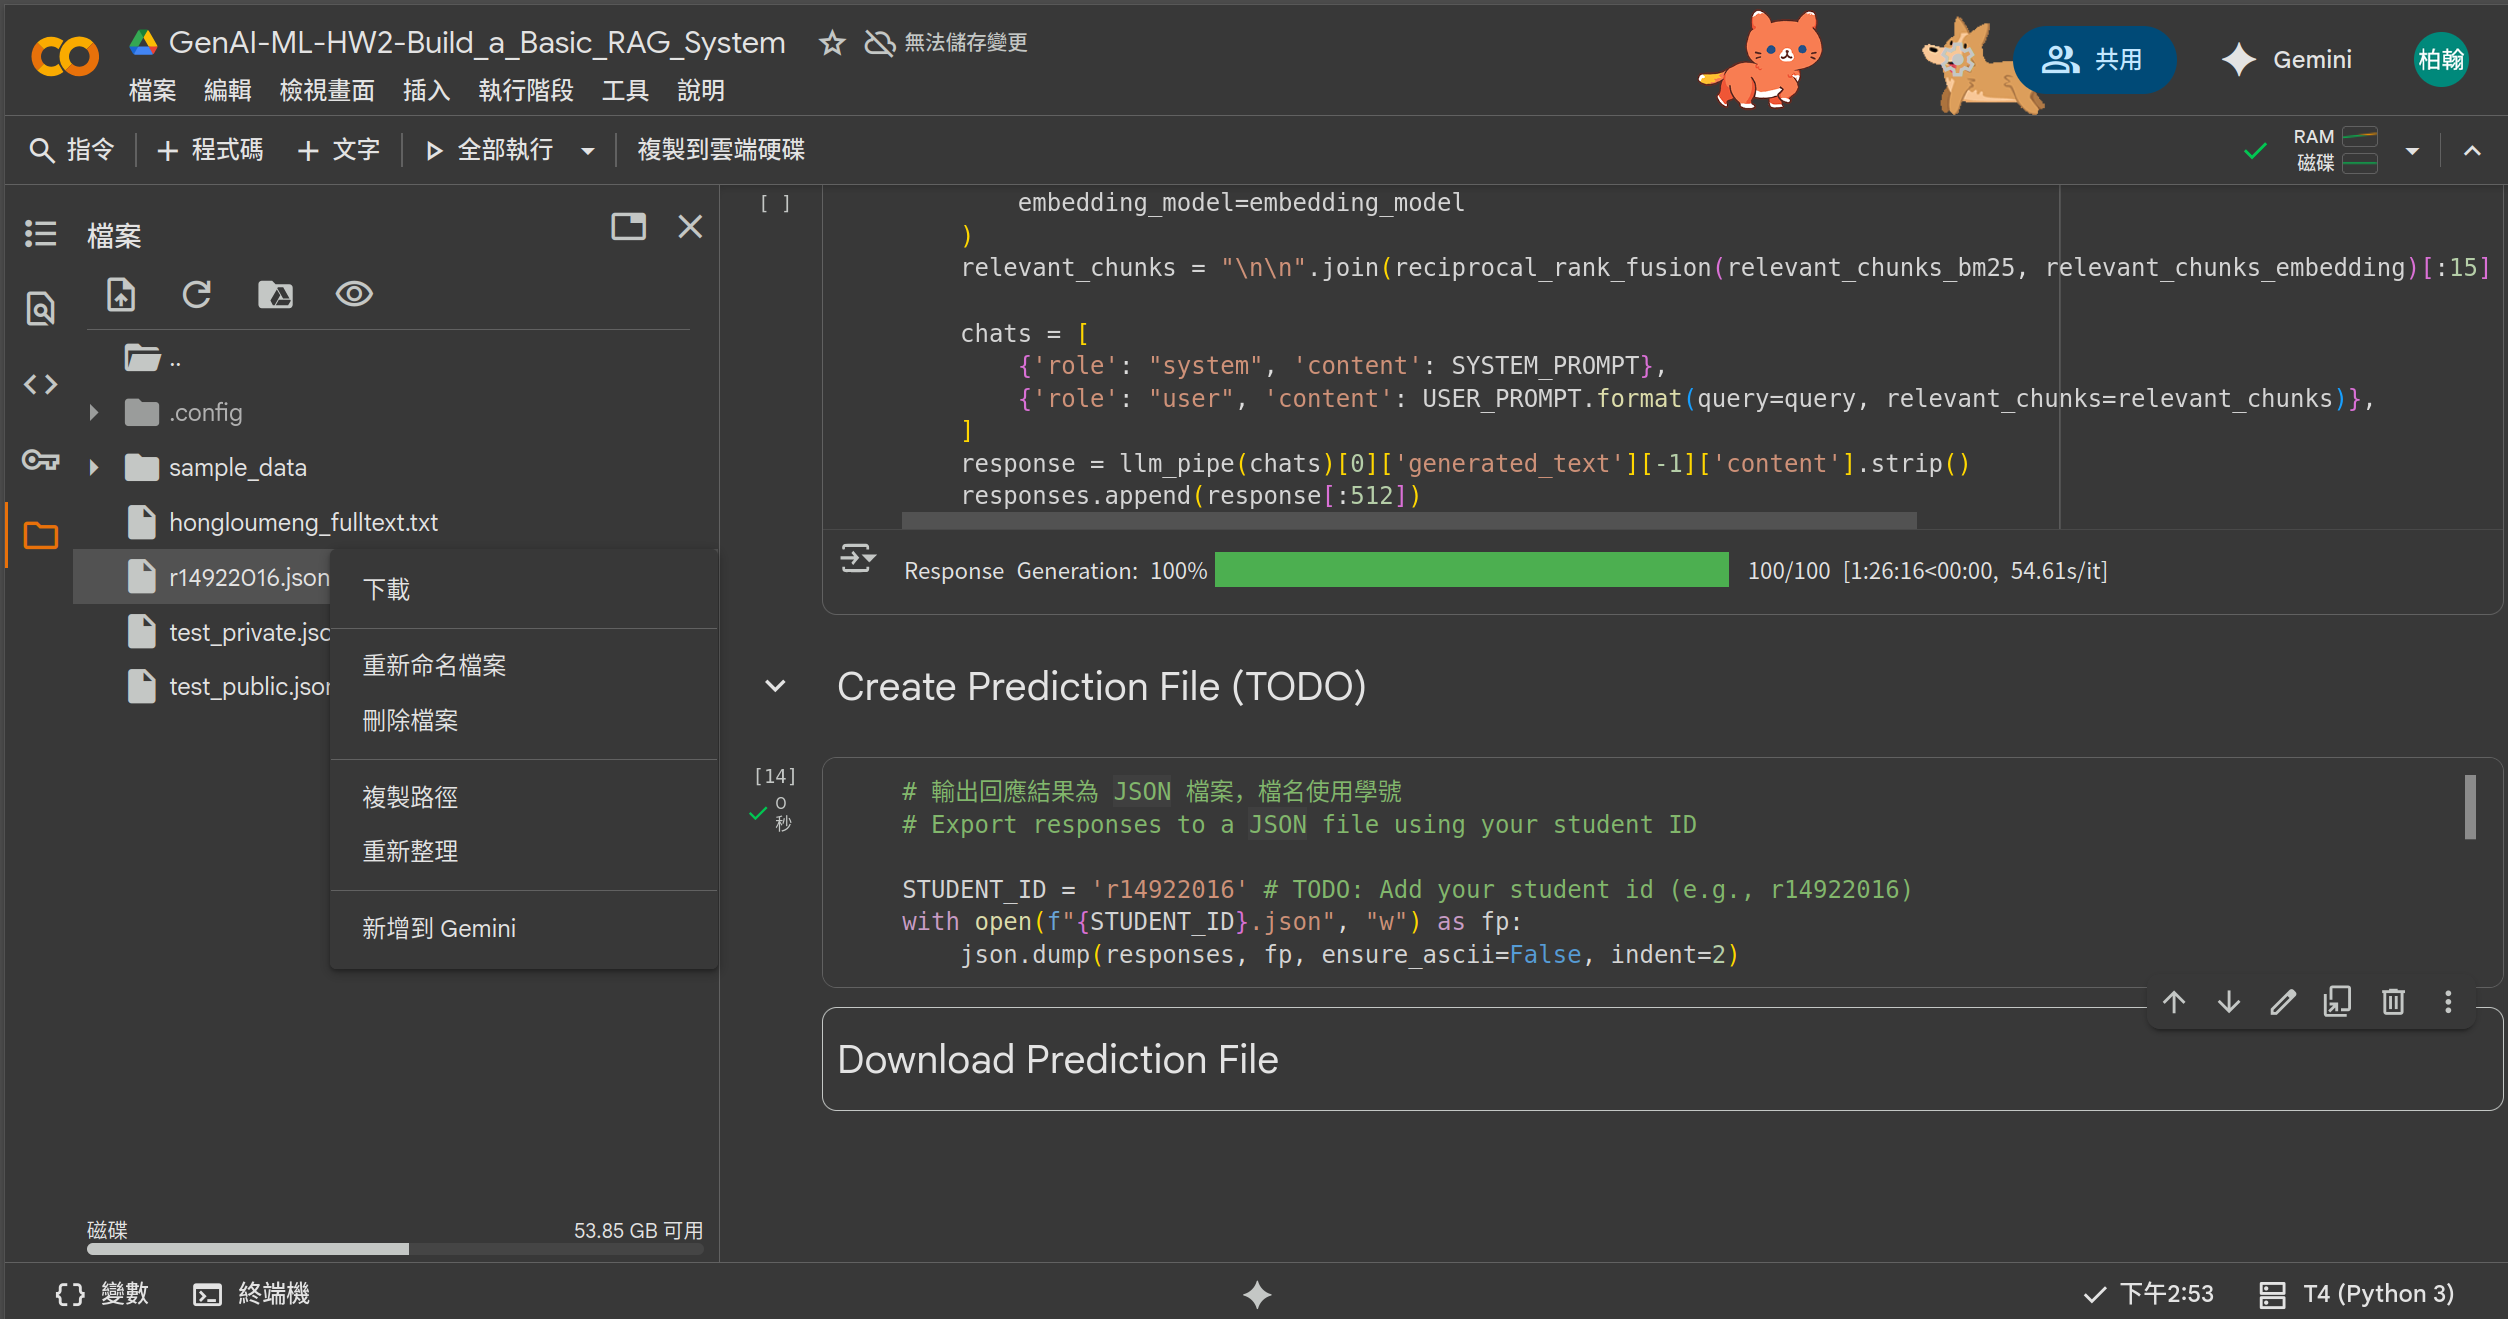

## Input & Output Examples

- Query: 薛蟠在秦氏喪事期間提供給賈珍的檣木棺材，原本是為哪位人物準備的？
- Answer: 義忠親王老千歲
- Simple Baseline (without RAG)
  - Input:
  ```python
  """
  <start_of_turn>user
  你是一位精通中國古典文學《紅樓夢》的專家。
  請根據提問，直接提供精簡並準確的解答，避免與問題無關的內容。

  薛蟠在秦氏喪事期間提供給賈珍的檣木棺材，原本是為哪位人物準備的？<end_of_turn>
  """
  ```
  - Output:
  ```python
  """
  <start_of_turn>model
  薛蟠為賈珍準備檣木棺材，原本是為元壽官準備的。<end_of_turn>
  """
  ```
- Medium Baseline (with RAG)
  - Input:
  ```python
  """
  <start_of_turn>user
  你是一位精通中國古典文學《紅樓夢》的專家。
  請根據**問題**，從使用者提供的**《紅樓夢》文章片段**找出與問題相關的內容，直接提供精簡並準確的解答，避免與問題無關的內容。

  ### 問題
  薛蟠在秦氏喪事期間提供給賈珍的檣木棺材，原本是為哪位人物準備的？
  ### 《紅樓夢》文章片段
  單八眾禪僧在大廳上拜大悲忏，超度前亡後化諸魂，以免亡者之罪，另設一壇于天香樓上，是九十九位全真道士，打四十九日解冤洗業醮。然後停靈于會芳園中，靈前另外五十眾高僧，五十眾高道，對壇按七作好事。那賈敬聞得長孫媳死了，因自為早晚就要飛升，如何肯又回家染了紅塵，將前功盡棄呢，因此并不在意，只憑賈珍料理。
  　　賈珍見父親不管，亦發恣意奢華。看板時，幾副杉木板皆不中用。可巧薛蟠來吊問，因見賈珍尋好板，便說道：“我們木店里有一副板，叫作什麼檣木，出在潢海鐵网山上，作了棺材，萬年不坏。這還是當年先父帶來，原系義忠親王老千歲要的，因他坏了事，就不曾拿去。現在還封在店內，也沒有人出价敢買。你若要，就抬來使罷。”賈珍聽說，喜之不盡，即命人抬來。大家看時，只見幫底皆厚八寸，紋若檳榔，味若檀麝，以手扣之，玎璫如金玉。大家都奇异稱贊。賈珍笑問：“价值幾何？”薛蟠笑道：“拿一千兩銀子來，只怕也沒處買去。什麼价不价，賞他們幾兩工錢就是了。”賈珍聽說，忙謝不盡，即命解鋸糊漆。賈政因勸道：“此物恐非常人可享者，殮以上等杉木也就是了。”此時賈珍恨不能代秦氏之死，這話如何肯聽。因忽又聽得秦氏之丫鬟名喚瑞珠者，見秦氏死了，他也触柱而亡。此事可罕，合

  不虞之隙。這日不知為何，他二人言語有些不合起來，黛玉又氣的獨在房中垂淚，寶玉又自悔言語冒撞，前去俯就，那黛玉方漸漸的回轉來。
  　　因東邊寧府中花園內梅花盛開，賈珍之妻尤氏乃治酒，請賈母，邢夫人，王夫人等賞花。是日先攜了賈蓉之妻，二人來面請。賈母等於早飯後過來，就在會芳園游頑，先茶後酒，不過皆是寧榮二府女眷家宴小集，並無別樣新文趣事可記。
  　　一時寶玉倦怠，欲睡中覺，賈母命人好生哄著，歇一回再來。賈蓉之妻秦氏便忙笑回道：「我們這裏有給寶叔收拾下的屋子，老祖宗放心，只管交與我就是了。」又向寶玉的奶娘丫鬟等道：「嬤嬤，姐姐們，請寶叔隨我這裡來。」賈母素知秦氏是個極妥當的人，生的裊娜纖巧，行事又溫柔和平，乃重孫媳中第一個得意之人，見他去安置寶玉，自是安穩的。
  　　當下秦氏引了一簇人來至上房內間。寶玉抬頭看見一幅畫貼在上面，畫的人物固好，其故事乃是《燃藜圖》，也不看係何人所畫，心中便有些不快。又有一幅對聯，寫的是：
  　　世事洞明皆學問，人情練達即文章。
  　　及看了這兩句，縱然室宇精美，舖陳華麗，亦斷斷不肯在這裡了，忙說：「快出去！快出去！」秦氏聽了笑道：「這裏 還不好，可往那裏去呢？不然往我屋裏去吧。」寶玉點

  兄弟一會子。我叫他兄弟到那邊府里找寶玉去了，我才看著他吃了半盞燕窩湯，我才過來了。嬸子，你說我心焦不心焦？況且如今又沒個好大夫，我想到他這病上，我心里倒象針扎似的。你們知道有什麼好大夫沒有？”
  　　金氏聽了這半日話，把方才在他嫂子家的那一團要向秦氏理論的盛氣，早嚇的都丟在爪洼國去了。聽見尤氏問他有知道好大夫的話，連忙答道：“我們這麼聽著，實在也沒見人說有個好大夫。如今聽起大奶奶這個來，定不得還是喜呢。嫂子倒別教人混治。倘或認錯了，這可是了不得的。”尤氏道：“可不是呢。”正是說話間，賈珍從外進來，見了金氏，便向尤氏問道：“這不是璜大奶奶么？”金氏向前給賈珍請了安。賈珍向尤氏說道：“讓這大妹妹吃了飯去。”賈珍說著話，就過那屋里去了。金氏此來，原要向秦氏說說秦鐘欺負了他侄兒的事，聽見秦氏有病，不但不能說，亦且不敢提了。況且賈珍尤氏又待的很好，反轉怒為喜，又說了一會子話兒，方家去了。
  　　金氏去後，賈珍方過來坐下，問尤氏道：“今日他來，有什麼說的事情么？”尤氏答道：“倒沒說什麼。一進來的時候，臉上倒象有些著了惱的氣色似的，及說了半天話，又提起媳婦這病，他倒漸漸的氣色平定了。你又叫讓他吃飯，他聽見媳婦這麼病，也不好

  書就要給你開筆，如今算來將兩個月了，你到底開了筆了沒有？”寶玉道：“才做過三次。師父說且不必回老爺知道，等好些再回老爺知道罷。因此這兩天總沒敢回。”賈政道：“是什麼題目？”寶玉道：“一個是《吾十有五而志于學》，一個是《人不知而不慍》，一個是《則歸墨》三字。”賈政道：“都有稿兒么？”寶玉道：“都是做了抄出來師父又改的。”賈政道：“你帶了家來了還是在學房里呢？”寶玉道：“在學房里呢。”賈政道：“叫人取了來我瞧。”寶玉連忙叫人傳話與焙茗：“叫他往學房中去，我書桌子抽屜里有一本薄薄兒竹紙本子，上面寫著‘窗課’兩字的就是，快拿來。”一回兒焙茗拿了來遞給寶玉。寶玉呈與賈政。賈政翻開看時，見頭一篇寫著題目是《吾十有五而志于學》。他原本破的是“圣人有志于學，幼而已然矣。”代儒卻將幼字抹去，明用“十五”。賈政道：“你原本‘幼’字便扣不清題目了。‘幼’字是從小起至十六以前都是‘幼’。這章書是圣人自言學問工夫與年俱進的話，所以十五，三十，四十，五十，六十，七十俱要明點出來，才見得到了幾時有這麼個光景，到了幾時又有那麼個光景。師父把你‘幼’字改了‘十五’，便明白了好些。”看到承題，那抹去的原本云：“夫不志于學，人之常也。”賈政搖頭道

  　　延胡索錢半 酒炒炙甘草八分
  　　引用建蓮子七粒去心紅棗二枚賈蓉看了，說：“高明的很。還要請教先生，這病與性命終久有妨無妨？”先生笑道：“大爺是最高明的人。人病到這個地位，非一朝一夕的症候，吃了這藥也要看醫緣了。依小弟看來，今年一冬是不相干的。總是過了春分，就可望全愈了。”賈蓉也是個聰明人，也不往下細問了。于是賈蓉送了先生去了，方將這藥方子并脈案都給賈珍看了，說的話也都回了賈珍并尤氏了。尤氏向賈珍說道：“從來大夫不象他說的這麼痛快，想必用的藥也不錯。”賈珍道：“人家原不是混飯吃久慣行醫的人。因為馮紫英我們好，他好容易求了他來了。既有這個人，媳婦的病或者就能好了。他那方子上有人參，就用前日買的那一斤好的罷。”賈蓉聽畢話，方出來叫人打藥去煎給秦氏吃。不知秦氏服了此藥病勢如何，下回分解。

  第十一回　慶壽辰宁府排家宴　見熙鳳賈瑞起淫心
  　　話說是日賈敬的壽辰，賈珍先將上等可吃的東西，稀奇些的果品，裝了十六大捧盒，著賈蓉帶領家下人等與賈敬送去，向賈蓉說道：“你留神看太爺喜歡不喜歡，你就行了禮來。你說：‘我父親遵太爺的話未敢來，在家里率領合家都朝上行了禮了。’”賈蓉聽罷，即率領家人去了。
  　　這里漸漸的就有人來

  拴上扣兒套在咽喉，便把腳凳蹬開。可怜咽喉氣絕，香魂出竅，正無投奔，只見秦氏隱隱在前，鴛鴦的魂魄疾忙赶上說道：“蓉大奶奶，你等等我。”那個人道：“我并不是什麼蓉大奶奶，乃警幻之妹可卿是也。”鴛鴦道：“你明明是蓉大奶奶，怎麼說不是呢？”那人道：“這也有個緣故，待我告訴你，你自然明白了。我在警幻宮中原是個鐘情的首坐，管的是風情月債，降臨塵世，自當為第一情人，引這些痴情怨女早早歸入情司，所以該當懸粱自盡的。因我看破凡情，超出情海，歸入情天，所以太虛幻境痴情一司竟自無人掌管。今警幻仙子已經將你補入，替我掌管此司，所以命我來引你前去的。”鴛鴦的魂道：“我是個最無情的，怎麼算我是個有情的人呢？”那人道：“你還不知道呢。世人都把那淫欲之事當作‘情’字，所以作出傷風敗化的事來，還自謂風月多情，無關緊要。不知‘情’之一字，喜怒哀樂未發之時便是個性，喜怒哀樂已發便是情了。至于你我這個情，正是未發之情，就如那花的含苞一樣，欲待發泄出來，這情就不為真情了。”鴛鴦的魂聽了點頭會意，便跟了秦氏可卿而去。
  　　這里琥珀辭了靈，聽邢王二夫人分派看家的人，想著去問鴛鴦明日怎樣坐車的，在賈母的外間屋里找了一遍不見，便找到套間里頭。剛到門口，見門

  頭微笑。有一個嬤嬤說道：「那裏有個叔叔往侄兒房里裏睡覺的理？」秦氏笑道：「噯喲喲，不怕他惱。他能多大呢，就忌諱這些個！上月你沒看見我那個兄弟來了，雖然與寶叔同年，兩個 人若站在一處，只怕那個還高些呢。」寶玉道：「我怎麼沒見過？你帶他來我瞧瞧。」眾人笑道：「隔著二三十里，往那裏帶去，見的日子有呢。」說著大家來至秦氏房中。剛至房門，便有一股細細的甜香襲人而來。寶玉覺得眼餳骨軟，連說「好香！」入房向壁上看時，有唐伯虎畫的《海棠春睡圖》，兩邊有宋學士秦太虛寫的一副對聯，其聯云：
  　　嫩寒鎖夢因春冷，芳氣襲人是酒香。
  　　案上設著武則天當日鏡室中設的寶鏡，一邊擺著飛燕立著舞過的金盤，盤內盛著安祿山擲過傷了太真乳的木瓜。上面設著壽昌公主於含章殿下臥的榻，懸的是同昌公主製的聯珠帳。寶玉含笑連說：「這裏好！」秦氏笑道：「我這屋子大約神仙也可以住得了。」說著親自展開了西子浣過的紗衾，移了紅娘抱過的鴛枕。於是眾奶母伏侍寶玉臥好，款款散了，只留襲人，媚人，晴雯，麝月四個丫鬟為伴。秦氏便吩咐小丫鬟們，好生在廊檐下看著貓兒狗兒打架。
  　　那寶玉剛合上眼，便惚惚的睡去，猶似秦氏在前，遂悠悠蕩蕩，隨了秦氏，至一所在。但見朱欄白石，綠

  在老太太身上，也是該當的。”鴛鴦道：“老太太的遺言說，所有剩下的東西是給我們的，二奶奶倘或用著不夠，只管拿這個去折變補上。就是老爺說什麼，我也不好違老太太的遺言。那日老太太分派的時候不是老爺在這里聽見的么。”鳳姐道：“你素來最明白的，怎麼這會子那樣的著急起來了。”鴛鴦道：“不是我著急，為的是大太太是不管事的，老爺是怕招搖的，若是二奶奶心里也是老爺的想頭，說抄過家的人家喪事還是這麼好，將來又要抄起來，也就不顧起老太太來，怎麼處！在我呢是個丫頭，好歹礙不著，到底是這里的聲名。”鳳姐道：“我知道了，你只管放心，有我呢！”鴛鴦千恩萬謝的托了鳳姐。
  　　那鳳姐出來想道：“鴛鴦這東西好古怪，不知打了什麼主意，論理老太太身上本該体面些。噯，不要管他，且按著咱們家先前的樣子辦去。”于是叫了旺兒家的來把話傳出去請二爺進來。不多時，賈璉進來，說道：“怎麼找我？你在里頭照應著些就是了。橫豎作主是咱們二老爺，他說怎麼著咱們就怎麼著。”鳳姐道：“你也說起這個話來了，可不是鴛鴦說的話應驗了么。”賈璉道：“什麼鴛鴦的話？”鳳姐便將鴛鴦請進去的話述了一遍。賈璉道：“他們的話算什麼。才剛二老爺叫我去，說老太太的事固要認真辦理，但是知道的呢，

  口供，你是親見的，怎麼如今說沒有見？”李二道：“小的前日唬昏了亂說。”衙役又吆喝了一聲。知縣便叫吳良問道：“你是同在一處喝酒的么？薛蟠怎麼打的，据實供來。”吳良說：“小的那日在家，這個薛大爺叫我喝酒。他嫌酒不好要換，張三不肯。薛大爺生氣把酒向他臉上潑去，不曉得怎麼樣就碰在那腦袋上了。這是親眼見的。”知縣道：“胡說。前日屍場上薛蟠自己認拿碗砸死的，你說你親眼見的，怎麼今日的供不對？掌嘴。”衙役答應著要打，吳良求著說：“薛蟠實沒有與張三打架，酒碗失手碰在腦袋上的。求老爺問薛蟠便是恩典了。”知縣叫提薛蟠，問道：“你與張三到底有什麼仇隙？畢竟是如何死的，實供上來。”薛蟠道：“求太老爺開恩，小的實沒有打他。為他不肯換酒，故拿酒潑他，不想一時失手，酒碗誤碰在他的腦袋上。小的即忙掩他的血，那里知道再掩不住，血淌多了，過一回就死了。前日屍場上怕太老爺要打，所以說是拿碗砸他的。只求太爺開恩。”知縣便喝道：“好個糊涂東西！本縣問你怎麼砸他的，你便供說惱他不換酒才砸的，今日又供是失手碰的。”知縣假作聲勢，要打要夾，薛蟠一口咬定。知縣叫仵作將前日屍場填寫傷痕据實報來。仵作稟報說：“前日驗得張三屍身無傷，惟鹵門有磁器傷長一寸七分，深五

  字一個也不認得，有的象“芍”字，有的象“茫”字，也有一個“大”字旁邊“九”字加上一勾，中間又添個“五”字，也有上頭“五”字“六”字又添一個“木”字，底下又是一個“五”字，看著又奇怪，又納悶，便說：“妹妹近日愈發進了，看起天書來了。”黛玉嗤的一聲笑道：“好個念書的人，連個琴譜都沒有見過。”寶玉道：“琴譜怎麼不知道，為什麼上頭的字一個也不認得。妹妹你認得么？”黛玉道：“不認得瞧他做什麼？”寶玉道：“我不信，從沒有聽見你會撫琴。我們書房里挂著好幾張，前年來了一個清客先生叫做什麼嵇好古，老爺煩他撫了一曲。他取下琴來說，都使不得，還說：‘老先生若高興，改日攜琴來請教。’想是我們老爺也不懂，他便不來了。怎麼你有本事藏著？”黛玉道：“我何嘗真會呢。前日身上略覺舒服，在大書架上翻書，看有一套琴譜，甚有雅趣，上頭講的琴理甚通，手法說的也明白，真是古人靜心養性的工夫。我在揚州也聽得講究過，也曾學過，只是不弄了，就沒有了。這果真是‘三日不彈，手生荊棘。’前日看這幾篇沒有曲文，只有操名。我又到別處找了一本有曲文的來看著，才有意思。究竟怎麼彈得好，實在也難。書上說的師曠鼓琴能來風雷龍鳳，孔圣人尚學琴于師襄，一操便知其為文王，高山流水，<end_of_turn>
  """
  ```
  - Output:
  ```python
  """
  <start_of_turn>model
  根據您提供的《紅樓夢》文章片段，與問題“薛蟠在秦氏喪事期間提供給賈珍的檣木棺材，原本是為哪位人物準備的？”相關的內容如下：

  薛蟠提到那檣木棺材是“當年先父帶來，原系義忠親王老千歲要的，他坏了事，就不曾拿去。現在還封在店內，也沒有人出价敢买。”

  **結論：** 因此，檣木棺材原本是為義忠親王老千歲準備的。<end_of_turn>
  """
  ```